# What is a distribution?

An object-oriented exploration of one of the most useful concepts in statistics.

Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 6

import warnings
warnings.filterwarnings('ignore')

from thinkbayes2 import Pmf, Cdf
import thinkplot

import numpy as np
from numpy.fft import fft, ifft

In [2]:
from inspect import getsourcelines

def show_code(func):
    lines, _ = getsourcelines(func)
    for line in lines:
        print(line, end='')

## Playing dice with the universe

One of the recurring themes of my books is the use of object-oriented programming to explore mathematical ideas.  Many mathematical entities are hard to define because they are so abstract.  Representing them in Python puts the focus on what operations each entity supports -- that is, what the objects can *do* -- rather than on what they *are*.

In this notebook, I explore the idea of a probability distribution, which is one of the most important ideas in statistics, but also one of the hardest to explain.

To keep things concrete, I'll start with one of the usual examples: rolling dice.  When you roll a standard six-sided die, there are six possible outcomes -- numbers 1 through 6 -- and all outcomes are equally likely.

If you roll two dice and add up the total, there are 11 possible outcomes -- numbers 2 through 12 -- but they are not equally likely.  The least likely outcomes, 2 and 12, only happen once in 36 tries; the most likely outcome happens 1 times in 6.

And if you roll three dice and add them up, you get a different set of possible outcomes with a different set of probabilities.

What I've just described are three random number generators, which are also called **random processes**.  The output from a random process is a **random variable**, or more generally a set of random variables.  And each random variable has **probability distribution**, which is the set of possible outcomes and the corresponding set of probabilities.

There are many ways to represent a probability distribution.  The most obvious is a **probability mass function**, or PMF, which is a function that maps from each possible outcome to its probability.  And in Python, the most obvious way to represent a PMF is a dictionary that maps from outcomes to probabilities.

`thinkbayes2` provides a class called `Pmf` that represents a probability mass function.  Each `Pmf` contains a dictionary named `d` that contains the values and probabilities.  To show how this class is used, I'll create a `Pmf` that represents a six-sided die:

In [3]:
d6 = Pmf()
for x in range(1, 7):
    d6[x] = 1

d6.Print()

1 1
2 1
3 1
4 1
5 1
6 1


Initially the "probabilities" are all 1, so the total probability in the `Pmf` is 6, which doesn't make a lot of sense.  In a proper, meaningful, PMF, the probabilities add up to 1, which implies that one outcome, and only one outcome, will occur (for any given roll of the die).

We can take this "unnormalized" distribution and make it a proper `Pmf` using the `Normalize` method.  Here's what the method looks like:

In [4]:
show_code(Pmf.Normalize)

    def Normalize(self, fraction=1):
        """Normalizes this PMF so the sum of all probs is fraction.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        if self.log:
            raise ValueError("Normalize: Pmf is under a log transform")

        total = self.Total()
        if total == 0:
            raise ValueError('Normalize: total probability is zero.')

        factor = fraction / total
        for x in self.d:
            self.d[x] *= factor

        return total


`Normalize` adds up the probabilities in the PMF and divides through by the total.  The result is a `Pmf` with probabilities that add to 1.

Here's how it's used:

In [5]:
d6.Normalize()
d6.Print()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


The fundamental operation provided by a `Pmf` is a "lookup"; that is, we can look up an outcome and get the corresponding probability.  `Pmf` provides `__getitem__`, so we can use bracket notation to look up an outcome:

In [6]:
d6[3]

0.166667

And if you look up a value that's not in the `Pmf`, the probability is 0.

In [7]:
d6[7]

0

**Exerise:** Create a `Pmf` that represents a six-sided die that is red on two sides and blue on the other four.

In [8]:
# Solution

die = Pmf(dict(red=2, blue=4))
die.Normalize()
die.Print()

blue 0.6666666666666666
red 0.3333333333333333


## Is that all there is?

So is a `Pmf` a distribution?  No.  At least in this framework, a `Pmf` is one of several representations of a distribution.  Other representations include the **cumulative distribution function**, or CDF, and the **characteristic function**.

These representations are equivalent in the sense that they all contain the same informaton; if I give you any one of them, you can figure out the others (and we'll see how soon).

So why would we want different representations of the same information?  The fundamental reason is that there are many different operations we would like to perform with distributions; that is, questions we would like to answer.  Some representations are better for some operations, but none of them is the best for all operations.

So what are the questions we would like a distribution to answer?  They include:

*  What is the probability of a given outcome?
*  What is the mean of the outcomes, taking into account their probabilities?
*  What is the variance, and other moments, of the outcome?
*  What is the probability that the outcome exceeds (or falls below) a threshold?
*  What is the median of the outcomes, that is, the 50th percentile?
*  What are the other percentiles?
*  How can get generate a random sample from this distribution, with the appropriate probabilities?
*  If we run two random processes and choose the maximum of the outcomes (or minimum), what is the distribution of the result?
*  If we run two random processes and add up the results, what is the distribution of the sum?

Each of these questions corresponds to a method we would like a distribution to provide.  But as I said, there is no one representation that answers all of them easily and efficiently.  So let's look at the different representations and see what they can do.

Getting back to the `Pmf`, we've already seen how to look up the probability of a given outcome.  Here's the code:

In [9]:
show_code(Pmf.__getitem__)

    def __getitem__(self, value):
        return self.d.get(value, 0)


Python dictionaries are implemented using hash tables, so we expect `__getitem__` to be fast.  In terms of algorithmic complexity, it is constant time, or $O(1)$.

## Moments and expecations

The `Pmf` representation is also good for computing mean, variance, and other moments.  Here's the implementation of `Pmf.Mean`:

In [10]:
show_code(Pmf.Mean)

    def Mean(self):
        """Computes the mean of a PMF.

        Returns:
            float mean
        """
        return sum(p * x for x, p in self.Items())


This implementation is efficient, in the sense that it is $O(n)$, and because it uses a comprehension to traverse the outcomes, the overhead is low. 

The implementation of `Pmf.Var` is similar:

In [11]:
show_code(Pmf.Var)

    def Var(self, mu=None):
        """Computes the variance of a PMF.

        mu: the point around which the variance is computed;
                if omitted, computes the mean

        returns: float variance
        """
        if mu is None:
            mu = self.Mean()

        return sum(p * (x-mu)**2 for x, p in self.Items())


And here's how they are used:

In [12]:
d6.Mean(), d6.Var()

(3.500000, 2.916667)

The structure of `Mean` and `Var` is the same: they traverse the outcomes and their probabilities, `x` and `p`, and add up the product of `p` and some function of `x`.

We can generalize this structure to compute the **expectation** of any function of `x`, which is defined as

$E[f] = \sum_x p(x) f(x)$

`Pmf` provides `Expect`, which takes a function object, `func`, and returns the expectation of `func`:

In [13]:
show_code(Pmf.Expect)

    def Expect(self, func):
        """Computes the expectation of func(x).

        Returns:
            expectation
        """
        return np.sum(p * func(x) for x, p in self.Items()) 


As an example, we can use `Expect` to compute the third central moment of the distribution: 

In [14]:
mu = d6.Mean()
d6.Expect(lambda x: (x-mu)**3)

0.000000

Because the distribution is symmetric, the third central moment is 0.

## Addition

The next question we'll answer is the last one on the list: if we run two random processes and add up the results, what is the distribution of the sum?  In other words, if the result of the first process is a random variable, $X$, and the result of the second is $Y$, what is the distribution of $X+Y$?

The `Pmf` representation of the distribution can answer this question pretty well, but we'll see later that the characteristic function is even better.

Here's the implementation:

In [15]:
show_code(Pmf.AddPmf)

    def AddPmf(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 + v2, p1 * p2)
        return pmf


The outer loop traverses the outcomes and probabilities of the first `Pmf`; the inner loop traverses the second `Pmf`.  Each time through the loop, we compute the sum of the outcome pair, `v1` and `v2`,  and the probability that the pair occurs.

Note that this method implicitly assumes that the two processes are independent; that is, the outcome from one does not affect the other.  That's why we can compute the probability of the pair by multiplying the probabilities of the outcomes.

To demonstrate this method, we'll start with `d6` again.  Here's what it looks like:

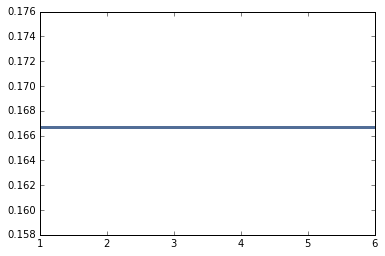

In [16]:
thinkplot.Pdf(d6)

When we use the `+` operator, Python invokes `__add__`, which invokes `AddPmf`, which returns a new `Pmf` object.  Here's the `Pmf` that represents the sum of two dice:

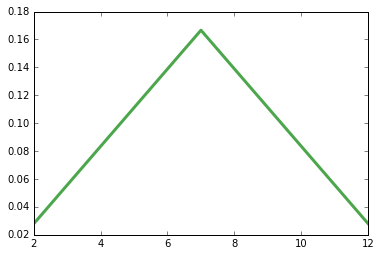

In [17]:
twice = d6 + d6
thinkplot.Pdf(twice, color='green')

And here's the `Pmf` that represents the sum of three dice.

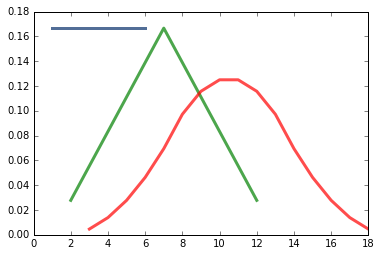

In [18]:
thrice = twice + d6
thinkplot.Pdf(d6)
thinkplot.Pdf(twice, color='green')
thinkplot.Pdf(thrice, color='red')

As we add up more dice, the result converges to the bell shape of the Gaussian distribution.

**Exercise:** If you did the previous exercise, you have a `Pmf` that represents a die with red on 2 sides and blue on the other 4.  Use the `+` operator to compute the outcomes of rolling two of these dice and the probabilities of the outcomes.

Note: if you represent the outcomes as strings, `AddPmf` concatenates them instead of adding, which actually works.

In [19]:
# Solution

dice = die + die
dice.Print()

blueblue 0.4444444444444444
bluered 0.2222222222222222
redblue 0.2222222222222222
redred 0.1111111111111111


## Cumulative probabilities

The next few questions on the list are related to the median and other percentiles.  They are harder to answer with the `Pmf` representation, but easier with a **cumulative distribution function** (CDF).

A CDF is a map from an outcome, $x$, to its cumulative probability, which is the probability that the outcome is less than or equal to $x$.  In math notation:

$CDF(x) = Prob(X \le x)$

where $X$ is the outcome of a random process, and $x$ is the threshold we are interested in.  For example, if $CDF$ is the cumulative distribution for the sum of three dice, the probability of getting 5 or less is $CDF(5)$, and the probability of getting 6 or more is $1 - CDF(5)$.

`thinkbayes2` provides a class called Cdf that represents a cumulative distribution function.  It uses a sorted list of outcomes and the corresponding list of cumulative probabilities.  The `__init__` method is complicated because it accepts a lot of different parameters.  The important part is the last 4 lines.

In [20]:
show_code(Cdf.__init__)

    def __init__(self, obj=None, ps=None, label=None):
        """Initializes.
        
        If ps is provided, obj must be the corresponding list of values.

        obj: Hist, Pmf, Cdf, Pdf, dict, pandas Series, list of pairs
        ps: list of cumulative probabilities
        label: string label
        """
        self.label = label if label is not None else DEFAULT_LABEL

        if isinstance(obj, (_DictWrapper, Cdf, Pdf)):
            if not label:
                self.label = label if label is not None else obj.label

        if obj is None:
            # caller does not provide obj, make an empty Cdf
            self.xs = np.asarray([])
            self.ps = np.asarray([])
            if ps is not None:
                logging.warning("Cdf: can't pass ps without also passing xs.")
            return
        else:
            # if the caller provides xs and ps, just store them          
            if ps is not None:
                if isinstance(ps, str):
                 

`xs` is the sorted list of values, and `freqs` are their frequencies or probabilities.

`ps` is the list of cumulative frequencies or probabilities, which we normalize by dividing through by the last element.

Here's how we use it to create a `Cdf` object for the sum of three dice:

In [21]:
cdf = Cdf(thrice)
cdf.Print()

3 0.00462962962963
4 0.0185185185185
5 0.0462962962963
6 0.0925925925926
7 0.162037037037
8 0.259259259259
9 0.375
10 0.5
11 0.625
12 0.740740740741
13 0.837962962963
14 0.907407407407
15 0.953703703704
16 0.981481481481
17 0.99537037037
18 1.0


Because we have to sort the values, the time to compute a `Cdf` is $O(n \log n)$.

Here's what the CDF looks like:

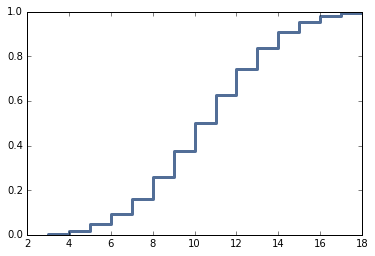

In [22]:
thinkplot.Cdf(cdf);

The range of the CDF is always from 0 to 1.

Now we can compute $CDF(x)$ by searching the `xs` to find the right location, or index, and then looking up the corresponding probability.  Because the `xs` are sorted, we can use bisection search, which is $O(\log n)$.

`Cdf` provides `Probs`, which takes an array of values and returns the corresponding probabilities:

In [23]:
show_code(Cdf.Probs)

    def Probs(self, xs):
        """Gets probabilities for a sequence of values.

        xs: any sequence that can be converted to NumPy array

        returns: NumPy array of cumulative probabilities
        """
        xs = np.asarray(xs)
        index = np.searchsorted(self.xs, xs, side='right')
        ps = self.ps[index-1]
        ps[xs < self.xs[0]] = 0
        return ps


The details here are a little tricky because we have to deal with some "off by one" problems, and if any of the values are less than the smallest value in the `Cdf`, we have to handle that as a special case.  But the basic idea is simple, and the implementation is efficient.

Now we can look up probabilities for a sequence of values:

In [24]:
cdf.Probs((2, 10, 18))

array([ 0. ,  0.5,  1. ])

`Cdf` also provides `__getitem__`, so we can use brackets to look up a single value:

In [25]:
cdf[5]

0.046296

**Exercise:** If you roll three dice, what is the probability of getting 15 or more?

In [26]:
# Solution

1 - cdf[14]

0.092593

## Reverse lookup

You might wonder why I represent a `Cdf` with two lists rather than a dictionary.  After all, a dictionary lookup is constant time and bisection search is logarithmic.  The reason is that we often want to use a `Cdf` to do a reverse lookup; that is, given a probability, we would like to find the corresponding value.  With two sorted lists, a reverse lookup has the same performance as a forward loopup, $O(\log n)$.

Here's the implementation:

In [27]:
show_code(Cdf.Values)

    def Values(self, ps=None):
        """Returns InverseCDF(p), the value that corresponds to probability p.

        If ps is not provided, returns all values.

        Args:
            ps: NumPy array of numbers in the range [0, 1]

        Returns:
            NumPy array of values
        """
        if ps is None:
            return self.xs

        ps = np.asarray(ps)
        if np.any(ps < 0) or np.any(ps > 1):
            raise ValueError('Probability p must be in range [0, 1]')

        index = np.searchsorted(self.ps, ps, side='left')
        return self.xs[index]


And here's an example that finds the 10th, 50th, and 90th percentiles:

In [28]:
cdf.Values((0.1, 0.5, 0.9))

array([ 7, 10, 14])

The `Cdf` representation is also good at generating random samples, by choosing a probability uniformly from 0 to 1 and finding the corresponding value.  Here's the method `Cdf` provides:

In [29]:
show_code(Cdf.Sample)

    def Sample(self, n):
        """Generates a random sample from this distribution.
        
        n: int length of the sample
        returns: NumPy array
        """
        ps = np.random.random(n)
        return self.ValueArray(ps)


The result is a NumPy array with the given `shape`.  The time to generate each random choice is $O(\log n)$

Here are some examples that use it.

In [30]:
cdf.Sample(1)

array([15])

In [31]:
cdf.Sample(6)

array([10,  9,  6, 13, 14,  9])

In [32]:
cdf.Sample((2, 2))

array([[10,  7],
       [12, 14]])

**Exercise:** Write a function that takes a `Cdf` object and returns the interquartile range (IQR), which is the difference between the 75th and 25th percentiles.

In [33]:
# Solution

def iqr(cdf):
    values = cdf.Values((0.25, 0.75))
    return np.diff(values)[0]

iqr(cdf)

5

## Max and min

The `Cdf` representation is particularly good for finding the distribution of a maximum.  For example, in Dungeons and Dragons, players create characters with random properties like strength and intelligence.  The properties are generated by rolling three dice and adding them, so the CDF for each property is the `Cdf` we used in this example.  Each character has 6 properties, so we might wonder what the distribution is for the best of the six.

Here's the method that computes it:

In [34]:
show_code(Cdf.Max)

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.Copy()
        cdf.ps **= k
        return cdf


To get the distribution of the maximum, we make a new `Cdf` with the same values as the original, and with the `ps` raised to the `k`th power.  Simple, right?

To see how it works, suppose you generate six properties and your best is only a 10.  That's unlucky, but you might wonder how unlucky.  So, what is the chance of rolling 3 dice six times, and never getting anything better than 10?

Well, that means that all six values were 10 or less.  The probability that each of them is 10 or less is $CDF(10)$, because that's what the CDF means.  So the probability that all 6 are 10 or less is $CDF(10)^6$.  

Now we can generalize that by replacing $10$ with any value of $x$ and $6$ with any integer $k$.  The result is $CDF(x)^k$, which is the probability that all $k$ rolls are $x$ or less, and that is the CDF of the maximum.

Here's how we use `Cdf.Max`:

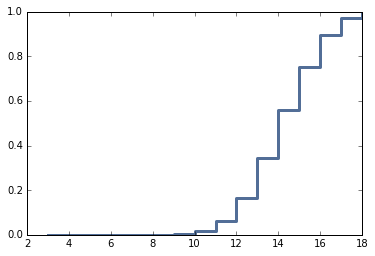

In [35]:
best = cdf.Max(6)
thinkplot.Cdf(best);

In [36]:
best[10]

0.015625

So the chance of generating a character whose best property is 10 is less than 2%.

**Exercise:**  Write a function that takes a CDF and returns the CDF of the *minimum* of `k` values.

Hint: If the minimum is less than $x$, that means all `k` values must be less than $x$.

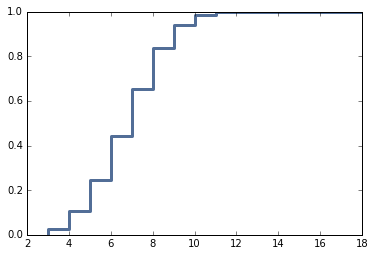

In [37]:
# Solution

def Min(cdf, k):
    return Cdf(cdf.xs, 1 - (1-cdf.ps)**k)

worst = Min(cdf, 6)
thinkplot.Cdf(worst);

## Characteristic function

At this point we've answered all the questions on the list, but I want to come back to addition, because the algorithm we used with the `Pmf` representation is not as efficient as it could be.  It enumerates all pairs of outcomes, so if there are $n$ values in each `Pmf`, the run time is $O(n^2)$.  We can do better.

The key is the **characteristic function**, which is the Fourier transform (FT) of the PMF.  If you are familiar with the Fourier transform and the Convolution Theorem, keep reading.  Otherwise, skip the rest of this cell and get to the code, which is much simpler than the explanation.

### Details for people who know about convolution

If you are familiar with the FT in the context of spectral analysis of signals, you might wonder why we would possibly want to compute the FT of a PMF.  The reason is the Convolution Theorem.

It turns out that the algorithm we used to "add" two `Pmf` objects is a form of convolution.  To see how that works, suppose we are computing the distribution of $Z = X+Y$.  To make things concrete, let's compute the probability that the sum, $Z$ is 5.  To do that, we can enumerate all possible values of $X$ like this:

$Prob(Z=5) = \sum_x Prob(X=x) \cdot Prob(Y=5-x)$

Now we can write each of those probabilities in terms of the PMF of $X$, $Y$, and $Z$:

$PMF_Z(5) = \sum_x PMF_X(x) \cdot PMF_Y(5-x)$

And now we can generalize by replacing 5 with any value of $z$:

$PMF_Z(z) = \sum_x PMF_X(x) \cdot PMF_Y(z-x)$

You might recognize that computation as convolution, denoted with the operator $\ast$.  

$PMF_Z = PMF_X \ast PMF_Y$

Now, according to the Convolution Theorem:

$FT(PMF_X \ast Y) = FT(PMF_X) \cdot FT(PMF_Y)$

Or, taking the inverse FT of both sides:

$PMF_X \ast PMF_Y = IFT(FT(PMF_X) \cdot FT(PMF_Y))$

In words, to compute the convolution of $PMF_X$ and $PMF_Y$, we can compute the FT of $PMF_X$ and $PMF_Y$ and multiply them together, then compute the inverse FT of the result.

Let's see how that works.  Here's a class that represents a characteristic function.

In [38]:
import matplotlib.pyplot as plt

class CharFunc:
    
    def __init__(self, hs):
        """Initializes the CF.
        
        hs: NumPy array of complex
        """
        self.hs = hs

    def __mul__(self, other):
        """Computes the elementwise product of two CFs."""
        return CharFunc(self.hs * other.hs)
        
    def make_pmf(self, thresh=1e-11):
        """Converts a CF to a PMF.
        
        Values with probabilities below `thresh` are dropped.
        """
        ps = ifft(self.hs)
        d = dict((i, p) for i, p in enumerate(ps.real) if p > thresh)
        return Pmf(d)
    
    def plot_cf(self, **options):
        """Plots the real and imaginary parts of the CF."""
        n = len(self.hs)
        xs = np.arange(-n//2, n//2)
        hs = np.roll(self.hs, len(self.hs) // 2)
        plt.plot(xs, hs.real, label='real', **options)
        plt.plot(xs, hs.imag, label='imag', **options)
        plt.legend()

The attribute, `hs`, is the Fourier transform of the `Pmf`, represented as a NumPy array of complex numbers.

The following function takes a dictionary that maps from outcomes to their probabilities, and computes the FT of the PDF:

In [39]:
def compute_fft(d, n=256):
    """Computes the FFT of a PMF of integers.
    
    Values must be integers less than `n`.
    """
    xs, freqs = zip(*d.items())
    ps = np.zeros(256)
    ps[xs,] = freqs
    hs = fft(ps)
    return hs

`fft` computes the Fast Fourier Transform (FFT), which is called "fast" because the run time is $O(n \log n)$.

Here's what the characteristic function looks like for the sum of three dice (plotting the real and imaginary parts of `hs`):

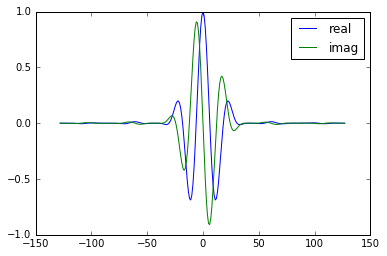

In [40]:
hs = compute_fft(thrice.d)
cf = CharFunc(hs)
cf.plot_cf()

The characteristic function contains all of the information from the `Pmf`, but it is encoded in a form that is hard to interpret.  However, if we are given a characteristic function, we can find the corresponding `Pmf`.

`CharFunc` provides `make_pmf`, which uses the inverse FFT to get back to the `Pmf` representation.  Here's the code:

In [41]:
show_code(CharFunc.make_pmf)

    def make_pmf(self, thresh=1e-11):
        """Converts a CF to a PMF.
        
        Values with probabilities below `thresh` are dropped.
        """
        ps = ifft(self.hs)
        d = dict((i, p) for i, p in enumerate(ps.real) if p > thresh)
        return Pmf(d)


And here's an example:

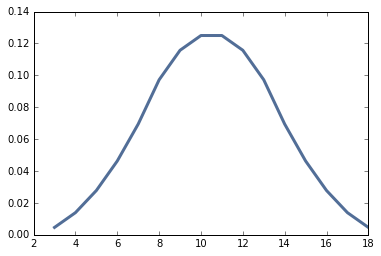

In [42]:
thinkplot.Pdf(cf.make_pmf())

Now we can use the characteristic function to compute a convolution.  `CharFunc` provides `__mul__`, which multiplies the `hs` elementwise and returns a new `CharFunc` object:

In [43]:
show_code(CharFunc.__mul__)

    def __mul__(self, other):
        """Computes the elementwise product of two CFs."""
        return CharFunc(self.hs * other.hs)


And here's how we can use it to compute the distribution of the sum of 6 dice.

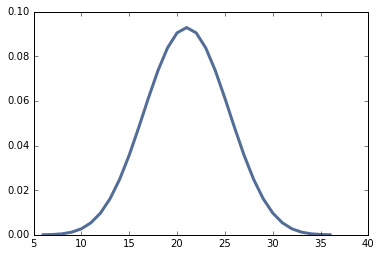

In [44]:
sixth = (cf * cf).make_pmf()
thinkplot.Pdf(sixth)

Here are the probabilities, mean, and variance.

In [45]:
sixth.Print()

6 2.14334705076e-05
7 0.000128600823045
8 0.000450102880659
9 0.00120027434842
10 0.00270061728395
11 0.0054012345679
12 0.00977366255144
13 0.0162037037037
14 0.0248842592593
15 0.0357081618656
16 0.0481610082305
17 0.0612139917695
18 0.0735382373114
19 0.0837191358025
20 0.0904706790123
21 0.0928497942387
22 0.0904706790123
23 0.0837191358025
24 0.0735382373114
25 0.0612139917695
26 0.0481610082305
27 0.0357081618656
28 0.0248842592593
29 0.0162037037037
30 0.00977366255144
31 0.0054012345679
32 0.00270061728395
33 0.00120027434842
34 0.000450102880658
35 0.000128600823045
36 2.14334705075e-05


In [46]:
sixth.Mean(), sixth.Var()

(21.000000, 17.500000)

This might seem like a roundabout way to compute a convolution, but it is efficient.  The time to Compute the `CharFunc` objects is $O(n \log n)$.  Multiplying them together is $O(n)$.  And converting back to a `Pmf` is $O(n \log n)$.

So the whole process is $O(n \log n)$, which is better than `Pmf.__add__`, which is $O(n^2)$.

**Exercise:** Plot the magnitude of `cf.hs` using `np.abs`.  What does that shape look like?

Hint: it might be clearer if you us `np.roll` to put the peak of the CF in the middle.

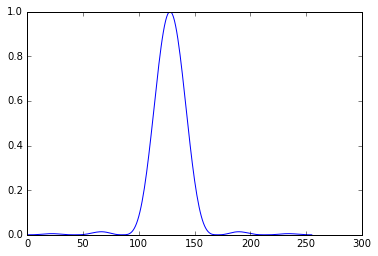

In [47]:
#Solution

n = len(cf.hs)
mags = np.abs(cf.hs)
plt.plot(np.roll(mags, n//2))
None

# The result approximates a Gaussian curve because 
# the PMF is approximately Gaussian and the FT of a 
# Gaussian is also Gaussian

## Distributions

Finally, let's back to the question we started with: *what is a distribution?*

I've said that `Pmf`, `Cdf`, and `CharFunc` are different ways to represent the same information.  For the questions we want to answer, some representations are better than others.  But how should we represent the distribution itself?

One option is to treat each representation as a **mixin**; that is, a class that provides a set of capabilities.  A distribution inherits all of the capabilities from all of the representations.  Here's a class that shows what I mean:

In [48]:
class Dist(Pmf, Cdf, CharFunc):
    
    def __init__(self, d):
        """Initializes the Dist.
        
        Calls all three __init__ methods.
        """
        Pmf.__init__(self, d)
        Cdf.__init__(self, d)
        CharFunc.__init__(self, compute_fft(d))
        
    def __add__(self, other):
        """Computes the distribution of the sum using Pmf.__add__.
        """
        pmf = Pmf.__add__(self, other)
        return Dist(pmf.d)
    
    def __mul__(self, other):
        """Computes the distribution of the sum using CharFunc.__mul__.
        """
        pmf = CharFunc.__mul__(self, other).make_pmf()
        return Dist(pmf.d)

When you create a `Dist`, you provide a dictionary of values and probabilities.

`Dist.__init__` calls the other three `__init__` methods to create the `Pmf`, `Cdf`, and `CharFunc` representations.  The result is an object that has all the attributes and methods of the three representations.

As an example, I'll create a `Dist` that represents the sum of six dice:

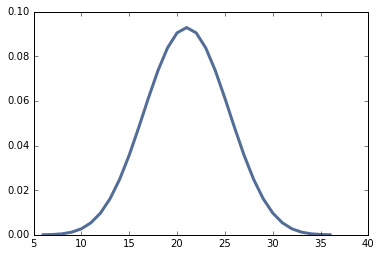

In [49]:
dist = Dist(sixth.d)
thinkplot.Pdf(dist)

We inherit `__getitem__` from `Pmf`, so we can look up the probability of a value.

In [50]:
dist[21]

0.092850

We also get mean and variance from `Pmf`:

In [51]:
dist.Mean(), dist.Var()

(21.000000, 17.500000)

But we can also use methods from `Cdf`, like `ValueArray`:

In [52]:
dist.ValueArray((0.25, 0.5, 0.75))

array([18, 21, 24])

And `Probs`

In [53]:
dist.Probs((18, 21, 24))

[0.073538, 0.092850, 0.073538]

And `Sample`

In [54]:
dist.Sample(10)

array([22, 19, 20, 21, 26, 26, 23, 16, 20, 19])

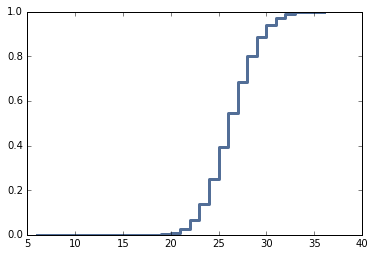

In [55]:
thinkplot.Cdf(dist.Max(6));

`Dist.__add__` uses `Pmf.__add__`, which performs convolution the slow way:

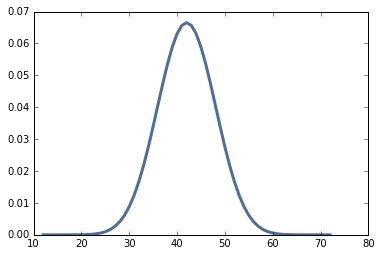

In [56]:
twelfth = dist + dist
thinkplot.Pdf(twelfth)

In [57]:
twelfth.Mean()

42.000000

`Dist.__mul__` uses `CharFunc.__mul__`, which performs convolution the fast way.

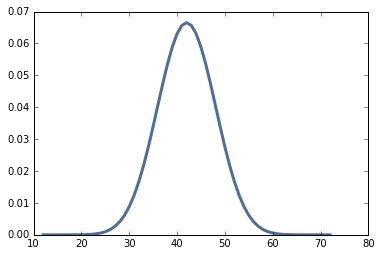

In [58]:
twelfth_fft = dist * dist
thinkplot.Pdf(twelfth_fft)

In [59]:
twelfth_fft.Mean()

42.000000

Either way, we get the answer, which is 42.

## Summary

Abstractly, a distribution is an entity that can answer questions about the outcomes of random variables and their probabilities.  There are many ways to represent a distribution; each representation is equivalent to the others in the sense that they contain the same information, and you can convert from any of them to the others.  

Some representations make it easy and efficient to answer some questions, but none of the representations is best for all of the questions.

In my implementation, a `Dist` object has the attributes and methods of all representations.  From a software engineering point of view, that might not be the best design, but it is meant to illustrate what it means to be a distribution.

In short, if you give me any representation of a distribution, you have told me everything I need to know to answer questions about the possible outcomes and their probabilities.  Converting from one representation to another is mostly a matter of convenience and computational efficiency.

Conversely, if you are trying to find the distribution of a random variable, you can do it by computing whichever representation is easiest to figure out.